In [ ]:
# ========================================
# Environment Setup
# ========================================
!pip install --upgrade transformers torch seaborn matplotlib scikit-learn imbalanced-learn nltk emoji langdetect swifter vaderSentiment kaggle sentencepiece textblob
!pip install pandas
!pip install umap-learn
!pip install keybert
!pip install hdbscan --quiet
!pip install sentence-transformers --quiet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Columns in the DataFrame:
['platform', 'software', 'review', 'country', 'title', 'text', 'date', 'score', 'num_comments', 'subreddit', 'developerResponse', 'rating', 'isEdited', 'userName']

Sample rows:
   platform software                                             review  \
0  Facebook   Taxfix  Unfortunately, I had deposited the wrong finan...   
1  Facebook   Taxfix  Sinnloses Gendergestammel! \nWer mit der deuts...   
2  Facebook   Taxfix  Sistem generated emails. I sent 10 Emails and ...   
3  Facebook   Taxfix  Scheint wohl bald dicht zu machen. Support ant...   
4  Facebook   Taxfix  They locked me out of my account by revoking l...   

   country title text date  score  num_comments subreddit developerResponse  \
0  Germany   NaN  NaN  NaN    NaN           NaN       NaN               NaN   
1  Germany   NaN  NaN  NaN    NaN           NaN       NaN               NaN   
2  Germany   NaN  NaN  NaN    NaN           NaN       NaN               NaN   
3  Germany   NaN  NaN  NaN   

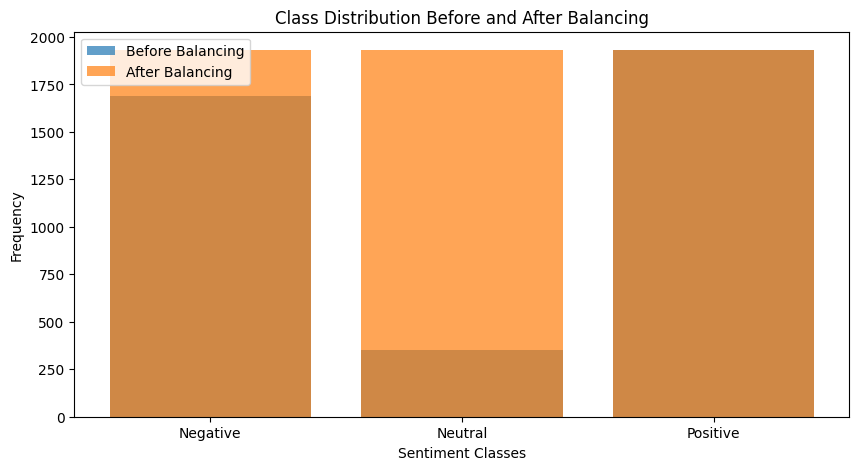

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilin

Training XLM-RoBERTa...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: pbeles (pbeles-ironhack). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.582400,0.575785,0.796376,0.806638,0.796376,0.796612
2,0.400700,0.350167,0.893874,0.898322,0.893874,0.893882
3,0.212900,0.337807,0.930975,0.933215,0.930975,0.930544
4,0.127400,0.304355,0.943917,0.944570,0.943917,0.943601
5,0.100400,0.316268,0.945643,0.945946,0.945643,0.945411


Training mBERT...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.475700,0.500738,0.812770,0.834279,0.812770,0.813595
2,0.291900,0.393198,0.879206,0.891488,0.879206,0.879245
3,0.068900,0.308535,0.922347,0.925780,0.922347,0.921330
4,0.015200,0.300988,0.947368,0.948415,0.947368,0.947152
5,0.080000,0.309116,0.947368,0.947740,0.947368,0.947118


Evaluating XLM-RoBERTa...


XLM-RoBERTa Confusion Matrix:
[[362  10  14]
 [  4 381   1]
 [ 20  14 353]]
Evaluating mBERT...


mBERT Confusion Matrix:
[[371   7   8]
 [  6 379   1]
 [ 25  14 348]]
Generating predictions for ensemble...


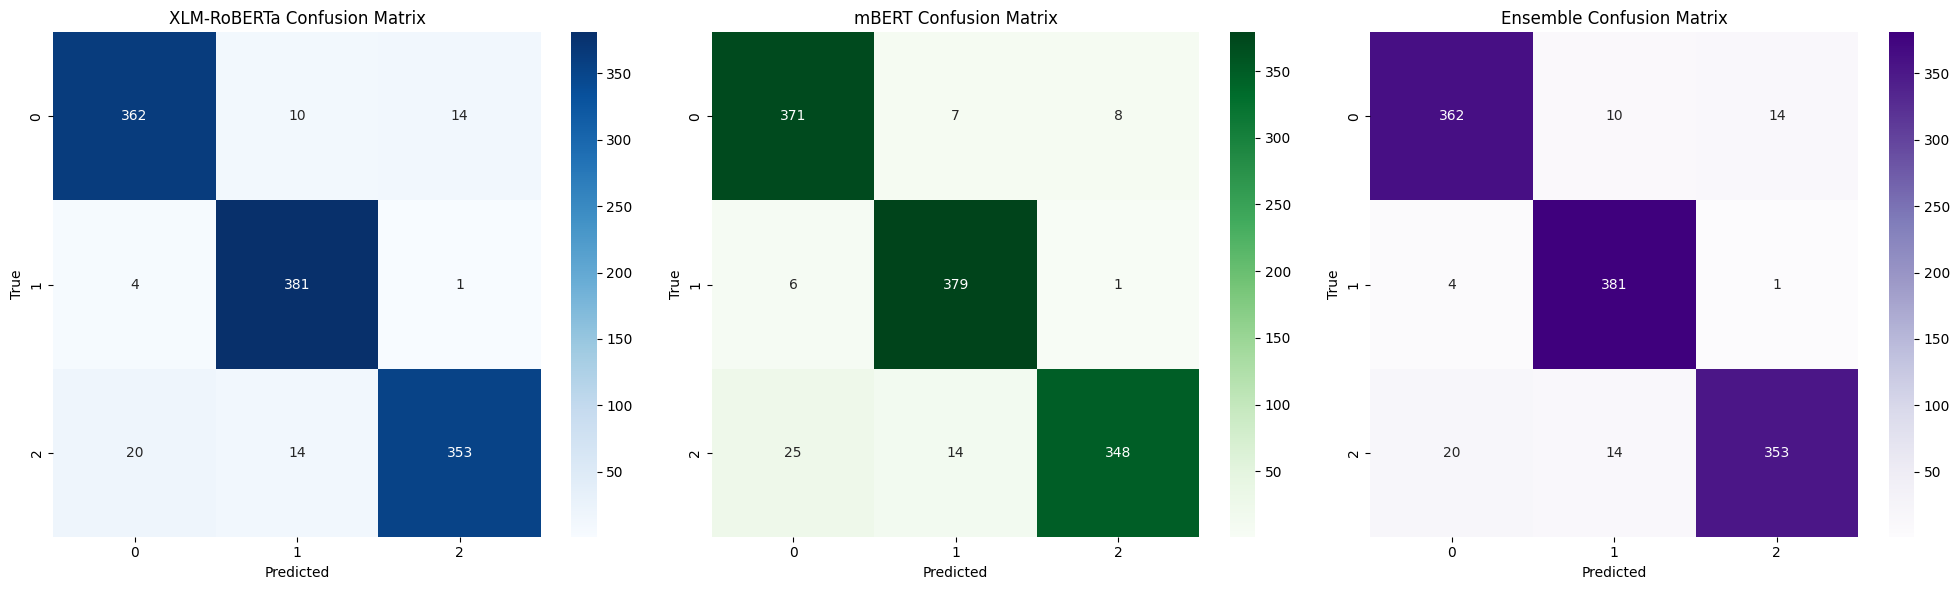

XLM-RoBERTa F1 Score: 0.9454113347784556
mBERT F1 Score: 0.9471515332254898
Ensemble F1 Score: 0.9454113347784556


('./mbert-sentiment/tokenizer_config.json',
 './mbert-sentiment/special_tokens_map.json',
 './mbert-sentiment/vocab.txt',
 './mbert-sentiment/added_tokens.json',
 './mbert-sentiment/tokenizer.json')

In [ ]:
# ========================================
# Setup and Environment Configuration
# ========================================
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.utils import resample
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import random
from transformers import (
    XLMRobertaTokenizer, XLMRobertaForSequenceClassification,
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments
)
import torch

# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Load the aggregated dataset
uploaded_data_path = "./aggregated_dataset.csv"  # Relative path to ensure accessibility
try:
    df = pd.read_csv(uploaded_data_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Dataset file not found at {uploaded_data_path}. Please ensure the file is placed correctly in the working directory.")

# Verify the structure of the dataset
print("Columns in the DataFrame:")
print(df.columns.tolist())
print("\nSample rows:")
print(df.head())

# ========================================
# Data Cleaning and Preprocessing
# ========================================
required_columns = ['review', 'rating']
for column in required_columns:
    if column not in df.columns:
        raise ValueError(f"The dataset must contain a '{column}' column.")

df = df.dropna(subset=['review', 'rating']).reset_index(drop=True)

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower().strip()
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

def rating_to_sentiment(r):
    if r < 3:
        return 0
    elif r == 3:
        return 1
    else:
        return 2

df['sentiment_label'] = df['rating'].apply(rating_to_sentiment)

# ========================================
# Data Balancing
# ========================================
class_counts = df['sentiment_label'].value_counts()
print("Class distribution before balancing:")
print(class_counts)

# Oversample minority classes to balance the dataset
df_majority = df[df['sentiment_label'] == class_counts.idxmax()]
df_minority = df[df['sentiment_label'] != class_counts.idxmax()]

balanced_dfs = [df_majority]
for label in df_minority['sentiment_label'].unique():
    minority_df = df_minority[df_minority['sentiment_label'] == label]
    oversampled_minority = resample(
        minority_df,
        replace=True,
        n_samples=len(df_majority),
        random_state=42
    )
    balanced_dfs.append(oversampled_minority)

df_balanced = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
print("Class distribution after balancing:")
print(df_balanced['sentiment_label'].value_counts())

# Plot class distributions
plt.figure(figsize=(10, 5))
plt.bar(class_counts.index, class_counts.values, alpha=0.7, label="Before Balancing")
plt.bar(df_balanced['sentiment_label'].value_counts().index, df_balanced['sentiment_label'].value_counts().values, alpha=0.7, label="After Balancing")
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.xlabel("Sentiment Classes")
plt.ylabel("Frequency")
plt.title("Class Distribution Before and After Balancing")
plt.legend()
plt.show()

#########################
# Save the cleaned and balanced dataset for future use
df_balanced.to_csv("./cleaned_balanced_dataset.csv", index=False)

# ========================================
# Model Ensemble: XLM-RoBERTa and mBERT
# ========================================
xlm_tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
xlm_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=3)

mbert_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
mbert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)

# Tokenize dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_balanced['cleaned_review'],
    df_balanced['sentiment_label'],
    test_size=0.2,
    random_state=42,
    stratify=df_balanced['sentiment_label']
)

xlm_train_encodings = xlm_tokenizer(list(train_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")
xlm_val_encodings = xlm_tokenizer(list(val_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")

mbert_train_encodings = mbert_tokenizer(list(train_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")
mbert_val_encodings = mbert_tokenizer(list(val_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item

    def __len__(self):
        return len(self.labels)

xlm_train_dataset = SentimentDataset(xlm_train_encodings, train_labels.tolist())
xlm_val_dataset = SentimentDataset(xlm_val_encodings, val_labels.tolist())

mbert_train_dataset = SentimentDataset(mbert_train_encodings, train_labels.tolist())
mbert_val_dataset = SentimentDataset(mbert_val_encodings, val_labels.tolist())

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_strategy="epoch"
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": (preds == labels).mean(),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }

xlm_trainer = Trainer(
    model=xlm_model,
    args=training_args,
    train_dataset=xlm_train_dataset,
    eval_dataset=xlm_val_dataset,
    tokenizer=xlm_tokenizer,
    compute_metrics=compute_metrics
)

mbert_trainer = Trainer(
    model=mbert_model,
    args=training_args,
    train_dataset=mbert_train_dataset,
    eval_dataset=mbert_val_dataset,
    tokenizer=mbert_tokenizer,
    compute_metrics=compute_metrics
)

print("Training XLM-RoBERTa...")
xlm_trainer.train()
print("Training mBERT...")
mbert_trainer.train()

# Evaluate individual models
print("Evaluating XLM-RoBERTa...")
xlm_results = xlm_trainer.evaluate()
xlm_preds = np.argmax(xlm_trainer.predict(xlm_val_dataset).predictions, axis=1)
xlm_conf_matrix = confusion_matrix(val_labels, xlm_preds)
print("XLM-RoBERTa Confusion Matrix:")
print(xlm_conf_matrix)

print("Evaluating mBERT...")
mbert_results = mbert_trainer.evaluate()
mbert_preds = np.argmax(mbert_trainer.predict(mbert_val_dataset).predictions, axis=1)
mbert_conf_matrix = confusion_matrix(val_labels, mbert_preds)
print("mBERT Confusion Matrix:")
print(mbert_conf_matrix)

# Ensemble predictions
print("Generating predictions for ensemble...")
ensemble_preds = [Counter([x, y]).most_common(1)[0][0] for x, y in zip(xlm_preds, mbert_preds)]
ensemble_conf_matrix = confusion_matrix(val_labels, ensemble_preds)
ensemble_f1 = f1_score(val_labels, ensemble_preds, average="weighted")

# Plot confusion matrices
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.heatmap(xlm_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title("XLM-RoBERTa Confusion Matrix")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")

sns.heatmap(mbert_conf_matrix, annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title("mBERT Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")

sns.heatmap(ensemble_conf_matrix, annot=True, fmt='d', cmap='Purples', ax=axs[2])
axs[2].set_title("Ensemble Confusion Matrix")
axs[2].set_xlabel("Predicted")
axs[2].set_ylabel("True")

plt.tight_layout()
plt.show()

# Performance comparison
print("XLM-RoBERTa F1 Score:", xlm_results['eval_f1'])
print("mBERT F1 Score:", mbert_results['eval_f1'])
print("Ensemble F1 Score:", ensemble_f1)

# Save models and tokenizers
xlm_model.save_pretrained("./xlmr-sentiment")
xlm_tokenizer.save_pretrained("./xlmr-sentiment")
mbert_model.save_pretrained("./mbert-sentiment")
mbert_tokenizer.save_pretrained("./mbert-sentiment")


In [ ]:
!pip install bertopic
!pip install --upgrade plotly ipywidgets


In [ ]:
import os
import torch
import plotly.express as px
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from bertopic import BERTopic
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from langdetect import detect
from umap import UMAP
import pandas as pd
import plotly.io as pio
import warnings

warnings.filterwarnings("ignore", category=UserWarning, message="The parameter 'n_components'")

# ------------------------------
# Configuration
# ------------------------------
DATA_PATH = "./cleaned_balanced_dataset.csv"
EMBEDDING_MODEL_NAME = "all-mpnet-base-v2"
PIO_RENDERER = 'colab'

pio.renderers.default = PIO_RENDERER

# ------------------------------
# Device Setup
# ------------------------------
use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"

if use_cuda:
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA not available. Using CPU.")

# ------------------------------
# Load and Validate Dataset
# ------------------------------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at path: {DATA_PATH}")

df_final = pd.read_csv(DATA_PATH)
print("Dataset loaded successfully.")

required_columns = ['sentiment_label', 'cleaned_review']
for col in required_columns:
    if col not in df_final.columns:
        raise ValueError(f"The dataset must include a '{col}' column.")

# Remove duplicates
df_final.drop_duplicates(subset='cleaned_review', inplace=True)

# ------------------------------
# Translation Setup
# ------------------------------
# Translate from German or Spanish to English if needed.
translation_device = 0 if use_cuda else -1
de_to_en_translator = pipeline("translation", model="Helsinki-NLP/opus-mt-de-en", device=translation_device)
es_to_en_translator = pipeline("translation", model="Helsinki-NLP/opus-mt-es-en", device=translation_device)

def translate_to_english(text: str) -> str:
    try:
        lang = detect(text)
    except:
        return text
    if lang == 'de':
        return de_to_en_translator(text)[0]['translation_text']
    elif lang == 'es':
        return es_to_en_translator(text)[0]['translation_text']
    else:
        return text

# Translate all reviews to English if needed
df_final['cleaned_review'] = df_final['cleaned_review'].astype(str).apply(translate_to_english)

def is_english(text: str) -> bool:
    try:
        return detect(text) == 'en'
    except:
        return False

df_final['is_english'] = df_final['cleaned_review'].apply(is_english)
df_final = df_final[df_final['is_english']]
df_final.drop(columns=['is_english'], inplace=True)
reviews = df_final['cleaned_review'].tolist()

# ------------------------------
# Embedding Model
# ------------------------------
try:
    embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME, device=device)
except RuntimeError as e:
    print(f"Error initializing SentenceTransformer: {e}")
    embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME, device="cpu")

# ------------------------------
# Vectorizer
# ------------------------------
custom_vectorizer_model = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8
)

# ------------------------------
# BERTopic Application
# ------------------------------
def apply_bertopic(df: pd.DataFrame,
                   sentiment_label: int,
                   vectorizer_model: TfidfVectorizer,
                   embedding_model: SentenceTransformer,
                   nr_topics: int = 15,
                   min_topic_size: int = 10):
    sentiment_reviews = df[df['sentiment_label'] == sentiment_label]['cleaned_review'].tolist()
    if len(sentiment_reviews) == 0:
        print(f"No reviews found for sentiment_label={sentiment_label}. Skipping.")
        return None, None, None, None

    sentiment_embeddings = embedding_model.encode(sentiment_reviews, show_progress_bar=True)
    print(f"Computed embeddings for {len(sentiment_reviews)} reviews.")

    umap_model = UMAP(
        n_neighbors=15,
        n_components=10,
        min_dist=0.0,
        random_state=42
    )

    topic_model = BERTopic(
        verbose=True,
        vectorizer_model=vectorizer_model,
        umap_model=umap_model,
        min_topic_size=min_topic_size
    )

    topics, probs = topic_model.fit_transform(sentiment_reviews, embeddings=sentiment_embeddings)
    outlier_count = sum(1 for t in topics if t == -1)
    print(f"Outliers (Topic -1): {outlier_count} documents.")

    # Reduce number of topics
    topic_model.reduce_topics(sentiment_reviews, nr_topics=nr_topics)
    reduced_topics = topic_model.get_topic_info()
    print("Topics after reduction:")
    print(reduced_topics.head(30))

    all_topics = topic_model.get_topics()

    # Extract topic terms
    topic_words = [topic_model.get_topic(t_id) for t_id in all_topics.keys() if t_id != -1 and topic_model.get_topic(t_id)]
    topic_terms = [[term for term, _ in words] for words in topic_words]

    # Clean up topic_terms: remove empty or whitespace-only terms
    cleaned_topic_terms = []
    for terms in topic_terms:
        cleaned = [t.strip() for t in terms if t.strip()]
        if cleaned:
            cleaned_topic_terms.append(cleaned)

    topic_terms = [t for t in cleaned_topic_terms if len(t) > 0]

    # If no valid topics remain after cleaning, skip coherence calculation
    if not topic_terms:
        print("No valid topics found after cleaning. Skipping coherence calculation.")
        return topic_model, topics, probs, sentiment_embeddings

    # Tokenize documents for coherence calculation
    tokenized_reviews = [review.split() for review in sentiment_reviews if isinstance(review, str) and review.strip()]
    dictionary = Dictionary(tokenized_reviews)

    # Compute coherence
    coherence_model = CoherenceModel(
        topics=topic_terms,
        texts=tokenized_reviews,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    print(f"Topic Coherence (C_V): {coherence_score:.4f}")

    return topic_model, topics, probs, sentiment_embeddings

# Apply BERTopic for negative sentiment
negative_topic_model, negative_topics, negative_probs, negative_embeddings = apply_bertopic(
    df_final,
    sentiment_label=0,
    vectorizer_model=custom_vectorizer_model,
    embedding_model=embedding_model,
    nr_topics=15,
    min_topic_size=5
)

# Apply BERTopic for positive sentiment
positive_topic_model, positive_topics, positive_probs, positive_embeddings = apply_bertopic(
    df_final,
    sentiment_label=2,
    vectorizer_model=custom_vectorizer_model,
    embedding_model=embedding_model,
    nr_topics=15,
    min_topic_size=5
)

# ------------------------------
# Topic Analysis and Visualization
# ------------------------------
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

from google.colab import output
output.enable_custom_widget_manager()

def analyze_topics(topic_model: BERTopic, title_prefix: str):
    """
    Prints topic overview, saves it to CSV, and visualizes various aspects of the topic model.
    """
    if topic_model is None:
        print(f"No topic model available for {title_prefix}.")
        return

    topics_overview = topic_model.get_topic_info()
    print(f"\n{title_prefix} Topic Overview:")
    print(topics_overview)
    topics_overview.to_csv(f"./{title_prefix.lower()}_topic_overview.csv", index=False)

    if len(topics_overview) <= 1:
        print(f"No meaningful topics to visualize for {title_prefix}.")
        return

    # Visualizations
    fig_bar = topic_model.visualize_barchart(top_n_topics=min(10, len(topics_overview)))
    fig_bar.show()

    fig_topics = topic_model.visualize_topics()
    fig_topics.show()

    fig_hierarchy = topic_model.visualize_hierarchy()
    fig_hierarchy.show()

    fig_heatmap = topic_model.visualize_heatmap()
    fig_heatmap.show()

    # Print top terms for top 10 topics
    top_10 = topics_overview.head(10)['Topic']
    for topic_id in top_10:
        if topic_id == -1:
            continue
        top_terms = topic_model.get_topic(topic_id)
        if top_terms:
            print(f"\n{title_prefix} Topic {topic_id} top terms:")
            for term, score in top_terms[:10]:
                print(f"{term}: {score:.4f}")

if negative_topic_model:
    analyze_topics(negative_topic_model, "Negative")
if positive_topic_model:
    analyze_topics(positive_topic_model, "Positive")

# Optional: Additional barcharts if desired and if topics exist
if negative_topic_model and negative_topic_model.get_topic_info().shape[0] > 1:
    fig_bar_neg = negative_topic_model.visualize_barchart(top_n_topics=min(14, len(negative_topic_model.get_topic_info())))
    fig_bar_neg.show()

if positive_topic_model and positive_topic_model.get_topic_info().shape[0] > 1:
    fig_bar_pos = positive_topic_model.visualize_barchart(top_n_topics=min(14, len(positive_topic_model.get_topic_info())))
    fig_bar_pos.show()


Using CUDA device: NVIDIA A100-SXM4-40GB
Dataset loaded successfully.


Device set to use cuda:0
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Batches:   0%|          | 0/28 [00:00<?, ?it/s]

2024-12-13 17:32:12,098 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Computed embeddings for 877 reviews.


2024-12-13 17:32:22,274 - BERTopic - Dimensionality - Completed ✓
2024-12-13 17:32:22,275 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-13 17:32:22,313 - BERTopic - Cluster - Completed ✓
2024-12-13 17:32:22,316 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-13 17:32:22,446 - BERTopic - Representation - Completed ✓
2024-12-13 17:32:22,594 - BERTopic - Topic reduction - Reducing number of topics
2024-12-13 17:32:22,699 - BERTopic - Topic reduction - Reduced number of topics from 29 to 15


Outliers (Topic -1): 235 documents.
Topics after reduction:
    Topic  Count                                    Name  \
0      -1    235                   -1_app_taxes_tax_year   
1       0    243                 0_tax_taxes_return_file   
2       1    100              1_invoice_app_invoices_web   
3       2     64                2_open_update_pro_closes   
4       3     47            3_password_account_app_login   
5       4     47  4_online_product_business_subscription   
6       5     28          5_credit_accounts_card_account   
7       6     26                6_card_check_balance_app   
8       7     20                7_money_pay_service_make   
9       8     17              8_app_mobile_years_invoice   
10      9     15              9_error_asks_address_sense   
11     10     10          10_log_failed_time try_logging   
12     11     10       11_delete_data_information_access   
13     12      8            12_load_dont_forward_biggest   
14     13      7              13_iphone_

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

2024-12-13 17:32:25,066 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Computed embeddings for 1133 reviews.


2024-12-13 17:32:29,172 - BERTopic - Dimensionality - Completed ✓
2024-12-13 17:32:29,174 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-13 17:32:29,219 - BERTopic - Cluster - Completed ✓
2024-12-13 17:32:29,223 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-13 17:32:29,338 - BERTopic - Representation - Completed ✓
2024-12-13 17:32:29,480 - BERTopic - Topic reduction - Reducing number of topics
2024-12-13 17:32:29,583 - BERTopic - Topic reduction - Reduced number of topics from 29 to 15


Outliers (Topic -1): 238 documents.
Topics after reduction:
    Topic  Count                                         Name  \
0      -1    238                         -1_tax_app_file_just   
1       0    249                      0_tax_file_return_years   
2       1    128                    1_credit_card_app_account   
3       2    107              2_app_version_expenses_features   
4       3     89                     3_tax_app_payment_saving   
5       4     85                   4_easy use_fast_user_great   
6       5     61                         5_app_fix_update_log   
7       6     61        6_quickbooks_accounts_online_software   
8       7     37              7_trust_doubt_team_professional   
9       8     34             8_declaration_income_doubts_make   
10      9     17                    9_pro_ipad_iphone_control   
11     10      8             10_truth_statement_right_present   
12     11      8  11_best_highly recommended_highly_recommend   
13     12      6              


Negative Topic 0 top terms:
tax: 0.0816
taxes: 0.0797
return: 0.0479
file: 0.0470
year: 0.0438
refund: 0.0374
pay: 0.0345
service: 0.0333
free: 0.0290
got: 0.0278

Negative Topic 1 top terms:
invoice: 0.0615
app: 0.0605
invoices: 0.0424
web: 0.0351
upload: 0.0320
screen: 0.0305
application: 0.0258
version: 0.0251
like: 0.0242
update: 0.0228

Negative Topic 2 top terms:
open: 0.1052
update: 0.0905
pro: 0.0663
closes: 0.0641
app: 0.0619
iphone: 0.0593
open app: 0.0588
ios: 0.0570
latest: 0.0412
latest update: 0.0402

Negative Topic 3 top terms:
password: 0.0785
account: 0.0755
app: 0.0675
login: 0.0450
reset: 0.0409
create: 0.0399
log: 0.0342
need: 0.0325
contact: 0.0315
company: 0.0310

Negative Topic 4 top terms:
online: 0.0425
product: 0.0421
business: 0.0371
subscription: 0.0364
app: 0.0333
problem: 0.0332
years: 0.0277
simple: 0.0267
help: 0.0264
desktop: 0.0259

Negative Topic 5 top terms:
credit: 0.2012
accounts: 0.0600
card: 0.0515
account: 0.0392
transactions: 0.0340
cards: 0.0


Positive Topic 0 top terms:
tax: 0.0816
file: 0.0605
return: 0.0552
years: 0.0449
app: 0.0423
year: 0.0360
free: 0.0359
used: 0.0298
using: 0.0292
im: 0.0260

Positive Topic 1 top terms:
credit: 0.3099
card: 0.0517
app: 0.0389
account: 0.0320
just: 0.0289
check: 0.0274
im: 0.0268
pay: 0.0257
information: 0.0245
dont: 0.0241

Positive Topic 2 top terms:
app: 0.0993
version: 0.0406
expenses: 0.0373
features: 0.0356
love: 0.0320
desktop: 0.0296
really: 0.0287
add: 0.0285
like: 0.0282
phone: 0.0281

Positive Topic 3 top terms:
tax: 0.0641
app: 0.0622
payment: 0.0503
saving: 0.0408
pay: 0.0386
save: 0.0376
account: 0.0314
payments: 0.0306
bank: 0.0303
self: 0.0295

Positive Topic 4 top terms:
easy use: 0.1032
fast: 0.0732
user: 0.0700
great: 0.0686
brilliant: 0.0616
business: 0.0602
quick: 0.0564
simple: 0.0523
friendly: 0.0488
software: 0.0455

Positive Topic 5 top terms:
app: 0.0835
fix: 0.0688
update: 0.0615
log: 0.0606
doesnt: 0.0442
enter: 0.0392
logging: 0.0375
issue: 0.0359
problem:

In [ ]:
!pip install bitsandbytes==0.42.0
!pip install --upgrade transformers accelerate
!pip install --force-reinstall -v “openai==1.55.3”


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.3/336.3 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.1.1
    Uninstalling accelerate-1.1.1:
      Successfully uninstalled accelerate-1.1.1


Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
ERROR: Invalid requirement: '“openai==1.55.3”': Expected package name at the start of dependency specifier
    “openai==1.55.3”
    ^


In [ ]:
# ========================================
# Summarization of Top Topics Using QwQ-32B-Preview LLM (4-bit)
# ========================================
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Load the Qwen-based model (unsloth quantization)
model_name = "Qwen/QwQ-32B-Preview"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)


model-00003-of-00017.safetensors:  22%|##1       | 849M/3.90G [00:00<?, ?B/s]

model-00004-of-00017.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00005-of-00017.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00006-of-00017.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00007-of-00017.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00008-of-00017.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00009-of-00017.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00010-of-00017.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00011-of-00017.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00012-of-00017.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00013-of-00017.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00014-of-00017.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00015-of-00017.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00016-of-00017.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00017-of-00017.safetensors:   0%|          | 0.00/3.10G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/17 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.38k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [ ]:
# Helper functions
def get_top_topics(topic_model, top_n=5):
    """Retrieve top N topics based on topic size from a BERTopic model."""
    topic_info = topic_model.get_topic_info()
    topic_info = topic_info[topic_info['Topic'] != -1].reset_index(drop=True)
    top_topics = topic_info.head(top_n)
    return top_topics

def get_topic_details(topic_model, topic_id, top_terms=10):
    """Get representative terms and sample documents for a specific topic."""
    topic_terms = topic_model.get_topic(topic_id)  # list of (term, score)
    terms_list = [term for term, score in topic_terms[:top_terms]]

    # Get representative documents (if available)
    representative_docs = topic_model.get_representative_docs(topic_id)
    if not representative_docs or len(representative_docs) == 0:
        representative_docs = ["No representative documents available."]

    return terms_list, representative_docs

# Extract top 5 topics for negative and positive
top_negative_topics = get_top_topics(negative_topic_model, top_n=5)
top_positive_topics = get_top_topics(positive_topic_model, top_n=5)

negative_topics_details = []
for idx, row in top_negative_topics.iterrows():
    topic_id = row['Topic']
    terms, docs = get_topic_details(negative_topic_model, topic_id)
    negative_topics_details.append({"topic_id": topic_id, "terms": terms, "docs": docs})

positive_topics_details = []
for idx, row in top_positive_topics.iterrows():
    topic_id = row['Topic']
    terms, docs = get_topic_details(positive_topic_model, topic_id)
    positive_topics_details.append({"topic_id": topic_id, "terms": terms, "docs": docs})

def create_prompt_for_summary(topics_details, sentiment_label):
    """
    Create a prompt for the LLM that describes the topics and asks for a summary.
    We'll present this as a user query in a Qwen-style prompt.
    """

    # Determine sentiment string
    sentiment = "positive" if sentiment_label == 2 else "negative"

    # Enhanced instructions: Incorporate role, regional focus, and stylistic guidance
    prompt = (
        f"You are a Senior Business Intelligence Analyst at a multinational tax software/fintech company.\n\n"
        f"As part of your responsibilities, you are reviewing the top {len(topics_details)} {sentiment} topics derived from user reviews. "
        f"These reviews are from users in America, England, Spain, and Germany. The goal is to understand what aspects of the company's tax software/fintech services "
        f"resonate positively or negatively with these users. Each topic includes representative terms and sample user excerpts.\n\n"
        f"**Instructions:**\n"
        f"- Carefully summarize the main ideas, user concerns or praises, recurring themes, and user sentiments.\n"
        f"- Highlight key user concerns or praises and their underlying reasons.\n"
        f"- Identify any region-specific differences or cultural nuances in feedback from America, England, Spain, and Germany.\n"
        f"- Maintain a professional, analytical tone and provide a coherent, concise summary that focuses on what users frequently mention.\n"
        f"- Consider any technical, usability, customer support, pricing, or feature-related aspects,duning, problems witht he calculation of the tax result that users mention.\n\n"
    )


    for i, t in enumerate(topics_details, start=1):
        prompt += (
            f"**Topic {i} (ID: {t['topic_id']})**:\n"
            f"Top Terms: {', '.join(t['terms'])}\n"
            f"Example User Excerpts:\n"
        )
        for d in t['docs'][:3]:
            prompt += f"- {d}\n"
        prompt += "\n"

    prompt += (
        "Now, synthesize these topics into a cohesive, regionally-aware summary. "
        "Focus on what users frequently mention, their main complaints or compliments, "
        "and the essence of their feedback. Identify any notable differences between user sentiments "
        "in America, England, Spain, and Germany. Your final answer should be a few well-structured paragraphs.\n"
    )
    return prompt

# Update the generate_summary function's system message to reflect your role and ensure step-by-step reasoning.
def generate_summary(prompt):
    """
    Generate a summary using the Qwen model format.
    """

    messages = [
        {
            "role": "system",
            "content": (
                "You are a helpful and harmless assistant. You are Qwen developed by Alibaba. "
                "You have deep domain expertise in analyzing user reviews for a tax software platform.Exclude credit "
                "Think step-by-step and follow the user's instructions carefully, providing a coherent and concise summary."
            )
        },
        {"role": "user", "content": prompt}
    ]

    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=256,
    do_sample=True,
    top_p=0.9,
    top_k=50
)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)]
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response


# The rest of your code remains the same
print("Summarizing Negative Topics...")
negative_summary = generate_summary(create_prompt_for_summary(negative_topics_details, sentiment_label=0))

print("Summarizing Positive Topics...")
positive_summary = generate_summary(create_prompt_for_summary(positive_topics_details, sentiment_label=2))

print("\n=== Negative Topics Summary ===")
print(negative_summary)

print("\n=== Positive Topics Summary ===")
print(positive_summary)


Summarizing Negative Topics...
Summarizing Positive Topics...

=== Negative Topics Summary ===
As a Senior Business Intelligence Analyst, I've been tasked with reviewing the top 5 negative topics derived from user reviews across America, England, Spain, and Germany for our tax software/fintech platform. The goal is to understand user sentiments and identify areas for improvement. Here's a summary of the main issues and themes extracted from the provided topics.

**Topic 1: Tax Filing Issues and Unexpected Changes**

Users across all regions express frustration with changes in tax filing processes and unexpected charges. In America, users mention being forced to upgrade to paid versions of software they previously used for free, feeling misled by advertising, and encountering issues with refund advances that weren't delivered as promised. For instance, TurboTax and HR Block are cited for changing their free services, now requiring payments for filing taxes, which has led to dissatisfact